In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

 # **Import dataset**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/1./train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/1./test.csv')

## **Visualize**

In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Sum up the counts for each toxicity category
toxicity_counts = train_df.iloc[:, 2:].sum()

<ipython-input-5-1226ac891b3b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")


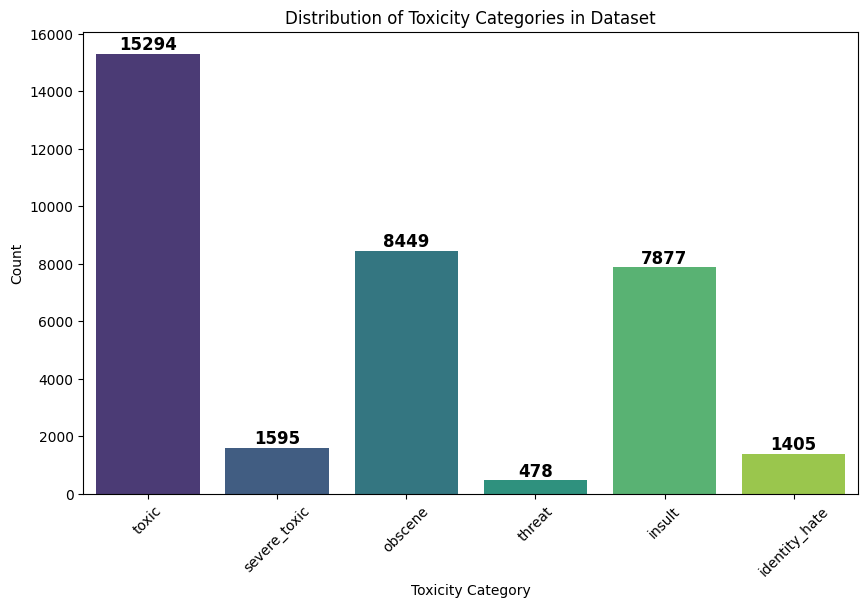

In [ ]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")

# Add number labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Customize labels and title
plt.xlabel("Toxicity Category")
plt.ylabel("Count")
plt.title("Distribution of Toxicity Categories in Dataset")
plt.xticks(rotation=45)
plt.show()

# **Clean The Dataset**

In [ ]:
# Download stopwords (if not already installed)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

In [ ]:
# Apply text cleaning
train_df['cleaned_comment'] = train_df['comment_text'].apply(clean_text)

In [ ]:
train_df['cleaned_comment'].head()

,cleaned_comment
0,explanation edits made username hardcore metal...
1,aww matches background colour seemingly stuck ...
2,hey man really trying edit war guy constantly ...
3,make real suggestions improvement wondered sec...
4,sir hero chance remember page


In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


# **Vectorize**

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Keep 5000 most important words
X_tfidf = vectorizer.fit_transform(train_df['cleaned_comment'])

# **Balanced dataset**

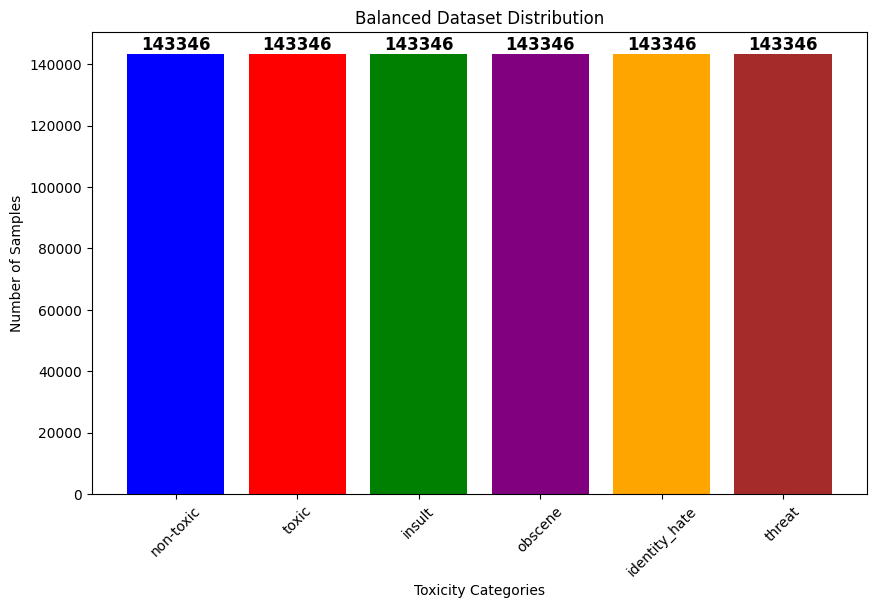

In [ ]:
# Get all toxicity labels
y_multilabel = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Define a custom function to get the dominant category
def get_dominant_category(row):
    """Returns the name of the category with the highest value."""
    max_col = row.idxmax()
    if row[max_col] == 1:  # Check if any category is 1
        return max_col
    else:
        return 'non-toxic'  # If all are 0, consider it non-toxic

# Apply the function to get a single label column
y_dominant = y_multilabel.apply(get_dominant_category, axis=1)

# Balance the dataset using RandomOverSampler on the dominant category
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled_dominant = ros.fit_resample(X_tfidf, y_dominant)

# Count the number of samples for each category after balancing
label_counts = y_resampled_dominant.value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green', 'purple', 'orange', 'brown', 'gray'])
plt.xlabel('Toxicity Categories')
plt.ylabel('Number of Samples')
plt.title('Balanced Dataset Distribution')

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=45)
plt.show()

# **Train dataset**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_dominant, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Train the model
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict on the test set
y_pred = log_reg.predict(X_test)

In [ ]:
# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Classification Report:
                precision    recall  f1-score   support

identity_hate       1.00      1.00      1.00     28760
       insult       0.96      0.99      0.98     28594
    non-toxic       0.90      0.90      0.90     28708
      obscene       0.96      1.00      0.98     28646
       threat       1.00      1.00      1.00     28608
        toxic       0.93      0.86      0.90     28700

     accuracy                           0.96    172016
    macro avg       0.96      0.96      0.96    172016
 weighted avg       0.96      0.96      0.96    172016

Accuracy: 0.9586259417728583


# **Import Pickle**

In [ ]:
# Save the model and vectorizer
import pickle

In [ ]:
# Use 'log_reg' instead of 'model'
with open("multi_label_logistic_regression.pkl", "wb") as model_file:
    pickle.dump(log_reg, model_file)  # Changed 'model' to 'log_reg'

with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)